# Clean Portfolio Optimization Testing

This notebook tests both Monte Carlo and Black-Litterman optimizers with properly aligned data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)
print("Clean Portfolio Optimization Testing")

Clean Portfolio Optimization Testing


## 1. Generate Clean Test Data

In [2]:
# Generate clean test data with proper alignment
n_periods = 120
n_assets = 12
n_factors = 6
n_regimes = 4

# Create date range
start_date = datetime(2015, 1, 31)
dates = [start_date + timedelta(days=30*i) for i in range(n_periods)]
dates = pd.to_datetime(dates)

# Asset universe (matching config)
assets = ['SPY', 'TLT', 'GLD', 'AAPL', 'MSFT', 'JPM', 'UNH', 'WMT', 'XLE', 'BA', 'IWM', 'EFA']

# Factor names
factor_names = ['GDP_Growth', 'Inflation', 'Interest_Rates', 'Unemployment', 'Oil_Prices', 'VIX']

# Regime names
regime_names = ['Bull_Market', 'Bear_Market', 'Sideways', 'Crisis']

print(f"Data dimensions:")
print(f"- Periods: {n_periods}")
print(f"- Assets: {n_assets}")
print(f"- Factors: {n_factors}")
print(f"- Regimes: {n_regimes}")

Data dimensions:
- Periods: 120
- Assets: 12
- Factors: 6
- Regimes: 4


In [3]:
# 1. Generate returns data
annual_returns = [0.10, 0.04, 0.08, 0.15, 0.12, 0.08, 0.11, 0.09, 0.12, 0.08, 0.08, 0.06]
annual_vols = [0.15, 0.12, 0.20, 0.25, 0.22, 0.18, 0.16, 0.20, 0.18, 0.25, 0.18, 0.16]

# Generate monthly returns with realistic correlations
returns_data = np.zeros((n_periods, n_assets))
for i, (ret, vol) in enumerate(zip(annual_returns, annual_vols)):
    monthly_ret = ret / 12
    monthly_vol = vol / np.sqrt(12)
    returns_data[:, i] = np.random.normal(monthly_ret, monthly_vol, n_periods)

returns_df = pd.DataFrame(returns_data, index=dates, columns=assets)
print("Returns data shape:", returns_df.shape)
print("\nSample returns:")
print(returns_df.head().round(4))

Returns data shape: (120, 12)

Sample returns:
               SPY     TLT     GLD    AAPL    MSFT     JPM     UNH     WMT  \
2015-01-31  0.0298  0.0307 -0.0391  0.0500  0.0019  0.0460  0.0234  0.0046   
2015-03-02  0.0023 -0.0282  0.0000  0.1231 -0.0507 -0.0413 -0.0698  0.0465   
2015-04-01  0.0364  0.0519  0.0358  0.0047 -0.0920  0.0519 -0.0531 -0.0573   
2015-05-01  0.0743 -0.0452  0.0567  0.0415  0.0229  0.0771  0.0435  0.0296   
2015-05-31 -0.0018  0.0237 -0.0626  0.0623 -0.0380  0.0281  0.0171  0.0171   

               XLE      BA     IWM     EFA  
2015-01-31  0.0434 -0.0185  0.0132  0.0076  
2015-03-02  0.0791 -0.0185 -0.0156  0.0295  
2015-04-01  0.0202 -0.0165  0.0130  0.0017  
2015-05-01  0.0468  0.1565  0.0349  0.0275  
2015-05-31  0.0053  0.0342  0.0092  0.0080  


In [4]:
# 2. Generate factor exposures (time-series)
factor_exposures = np.random.normal(0, 0.3, (n_periods, n_factors))

# Add realistic trends and patterns
factor_exposures[:, 0] += 0.5  # GDP growth trend
factor_exposures[:, 2] += -0.3  # Interest rate sensitivity
factor_exposures[:, 4] += 0.4   # Oil price sensitivity

factor_exposures_df = pd.DataFrame(factor_exposures, index=dates, columns=factor_names)
print("Factor exposures shape:", factor_exposures_df.shape)
print("\nSample factor exposures:")
print(factor_exposures_df.head().round(3))

Factor exposures shape: (120, 6)

Sample factor exposures:
            GDP_Growth  Inflation  Interest_Rates  Unemployment  Oil_Prices  \
2015-01-31       0.699      0.352          -0.246        -0.389       0.520   
2015-03-02       0.341      0.176           0.071         0.006       0.493   
2015-04-01       0.572      0.781          -0.130        -0.528       0.626   
2015-05-01       0.887      0.202          -0.342        -0.367       0.337   
2015-05-31       0.326      0.177           0.201         0.118       0.041   

              VIX  
2015-01-31 -0.195  
2015-03-02  0.511  
2015-04-01  0.114  
2015-05-01 -0.255  
2015-05-31  0.133  


In [5]:
# 3. Generate regime data in the format expected by Monte Carlo (regime_0_prob, regime_1_prob, etc.)
regime_data = np.zeros((n_periods, n_regimes))

# Create regime transitions
for i in range(n_periods):
    if i < 30:  # First 30 periods: Regime 0 (Bull market)
        regime_data[i] = [0.8, 0.05, 0.1, 0.05]
    elif i < 60:  # Next 30 periods: Regime 1 (Bear market)
        regime_data[i] = [0.1, 0.7, 0.15, 0.05]
    elif i < 90:  # Next 30 periods: Regime 2 (Sideways)
        regime_data[i] = [0.2, 0.1, 0.6, 0.1]
    else:  # Last 30 periods: Regime 3 (Crisis)
        regime_data[i] = [0.05, 0.2, 0.1, 0.65]

# Create DataFrame with numbered regime columns (like the real system produces)
regime_columns = [f'regime_{i}_prob' for i in range(n_regimes)]
regime_df = pd.DataFrame(regime_data, index=dates, columns=regime_columns)

# Add regime column with integer values (dominant regime)
regime_df['regime'] = np.argmax(regime_data, axis=1)

print("Regime data shape:", regime_df.shape)
print("Regime columns:", list(regime_df.columns))
print("\nSample regime probabilities:")
print(regime_df.head().round(3))

Regime data shape: (120, 5)
Regime columns: ['regime_0_prob', 'regime_1_prob', 'regime_2_prob', 'regime_3_prob', 'regime']

Sample regime probabilities:
            regime_0_prob  regime_1_prob  regime_2_prob  regime_3_prob  regime
2015-01-31            0.8           0.05            0.1           0.05       0
2015-03-02            0.8           0.05            0.1           0.05       0
2015-04-01            0.8           0.05            0.1           0.05       0
2015-05-01            0.8           0.05            0.1           0.05       0
2015-05-31            0.8           0.05            0.1           0.05       0


In [6]:
# 4. Generate sentiment data
sentiment_names = ['Earnings_Sentiment', 'Fed_Sentiment', 'Growth_Sentiment', 'Inflation_Sentiment', 
                   'Recession_Sentiment', 'Oil_Sentiment', 'Tech_Sentiment', 'Financial_Sentiment']

sentiment_data = np.random.normal(0, 0.3, (n_periods, len(sentiment_names)))
sentiment_df = pd.DataFrame(sentiment_data, index=dates, columns=sentiment_names)

print("Sentiment data shape:", sentiment_df.shape)
print("\nSample sentiment data:")
print(sentiment_df.head().round(3))

Sentiment data shape: (120, 8)

Sample sentiment data:
            Earnings_Sentiment  Fed_Sentiment  Growth_Sentiment  \
2015-01-31              -0.333          0.074             0.149   
2015-03-02              -0.070          0.140             0.296   
2015-04-01              -0.482          0.055             0.607   
2015-05-01              -0.664          0.460            -0.427   
2015-05-31               0.607         -0.409             0.057   

            Inflation_Sentiment  Recession_Sentiment  Oil_Sentiment  \
2015-01-31                0.342                0.474         -0.305   
2015-03-02               -0.023               -0.096          0.046   
2015-04-01                0.002               -0.057         -0.107   
2015-05-01               -0.080               -0.129          0.177   
2015-05-31               -0.199                0.128          0.006   

            Tech_Sentiment  Financial_Sentiment  
2015-01-31          -0.243               -0.377  
2015-03-02     

In [7]:
# 5. Generate macro data
macro_data = np.random.normal(0, 0.5, (n_periods, n_factors))

# Add realistic trends
macro_data[:, 1] += np.linspace(0, 0.5, n_periods)  # Inflation trend
macro_data[:, 2] += np.linspace(0, 1.0, n_periods)  # Interest rate trend

macro_df = pd.DataFrame(macro_data, index=dates, columns=factor_names)
print("Macro data shape:", macro_df.shape)
print("\nSample macro data:")
print(macro_df.head().round(3))

Macro data shape: (120, 6)

Sample macro data:
            GDP_Growth  Inflation  Interest_Rates  Unemployment  Oil_Prices  \
2015-01-31      -0.242     -0.306           0.246        -0.179      -0.070   
2015-03-02      -0.955      0.663           0.045        -0.206      -0.045   
2015-04-01      -0.866      0.756           0.037         0.222       0.476   
2015-05-01       0.237     -0.121           0.449        -1.064      -0.050   
2015-05-31       0.216      0.252          -0.320        -0.356      -0.055   

              VIX  
2015-01-31  0.370  
2015-03-02 -0.019  
2015-04-01 -0.511  
2015-05-01 -0.301  
2015-05-31 -0.448  


## 2. Test Portfolio Optimization

In [8]:
# Import optimization modules
import sys
sys.path.append('..')

from quantfolio_engine.optimizer.portfolio_engine import PortfolioOptimizationEngine

# Create data dictionary
data = {
    'returns': returns_df,
    'factor_exposures': factor_exposures_df,
    'factor_regimes': regime_df,
    'sentiment': sentiment_df,
    'macro': macro_df
}

print("Data shapes:")
print(f"Returns: {data['returns'].shape}")
print(f"Factor exposures: {data['factor_exposures'].shape}")
print(f"Factor regimes: {data['factor_regimes'].shape}")
print(f"Sentiment: {data['sentiment'].shape}")
print(f"Macro: {data['macro'].shape}")

# Verify date alignment
print("\nDate alignment check:")
print(f"Returns dates: {data['returns'].index[0]} to {data['returns'].index[-1]}")
print(f"Factor exposures dates: {data['factor_exposures'].index[0]} to {data['factor_exposures'].index[-1]}")
print(f"Regime dates: {data['factor_regimes'].index[0]} to {data['factor_regimes'].index[-1]}")

2025-07-05 20:06:56.744 | INFO     | quantfolio_engine.config:<module>:14 - PROJ_ROOT path is: /Users/dominusdeorum/Documents/Vanderbilt/Projects/quantfolio-engine


Data shapes:
Returns: (120, 12)
Factor exposures: (120, 6)
Factor regimes: (120, 5)
Sentiment: (120, 8)
Macro: (120, 6)

Date alignment check:
Returns dates: 2015-01-31 00:00:00 to 2024-11-09 00:00:00
Factor exposures dates: 2015-01-31 00:00:00 to 2024-11-09 00:00:00
Regime dates: 2015-01-31 00:00:00 to 2024-11-09 00:00:00


In [9]:
# Test Monte Carlo optimization
print("Testing Monte Carlo optimization...")
mc_engine = PortfolioOptimizationEngine(method='monte_carlo', risk_free_rate=0.045)
mc_result = mc_engine.optimize_portfolio(
    data=data,
    constraints={'max_weight': 0.20, 'min_weight': 0.03}
)

print("\nMonte Carlo Results:")
print(f"Expected Return: {mc_result['expected_return']:.3f}")
print(f"Volatility: {mc_result['volatility']:.3f}")
print(f"Sharpe Ratio: {mc_result['sharpe_ratio']:.3f}")
print(f"Max Drawdown: {mc_result['max_drawdown']:.3f}")
print(f"VaR (95%): {mc_result['var_95']:.3f}")

print("\nOptimal Weights:")
for asset, weight in mc_result['weights'].items():
    print(f"  {asset}: {weight:.3f}")

# Validate constraints
weights_array = np.array(list(mc_result['weights'].values))
print(f"\nConstraint validation:")
print(f"Weights sum to 1: {abs(np.sum(weights_array) - 1) < 0.01}")
print(f"All weights >= 0: {np.all(weights_array >= 0)}")
print(f"All weights <= max_weight: {np.all(weights_array <= 0.20)}")

Testing Monte Carlo optimization...
2025-07-05 20:06:56.998 | INFO     | quantfolio_engine.optimizer.portfolio_engine:optimize_portfolio:205 - Starting portfolio optimization using monte_carlo method...
2025-07-05 20:06:57.015 | INFO     | quantfolio_engine.optimizer.portfolio_engine:_optimize_monte_carlo:303 - Running Monte Carlo optimization...
2025-07-05 20:06:57.015 | INFO     | quantfolio_engine.optimizer.monte_carlo:generate_scenarios:91 - Generating 1000 Monte Carlo scenarios...
2025-07-05 20:06:57.023 | INFO     | quantfolio_engine.optimizer.monte_carlo:generate_scenarios:110 - Generated scenarios with shape: (1000, 12, 12)
2025-07-05 20:06:57.024 | INFO     | quantfolio_engine.optimizer.monte_carlo:optimize_with_constraints:136 - Optimizing portfolio with Monte Carlo constraints...
2025-07-05 20:06:57.024 | INFO     | quantfolio_engine.optimizer.monte_carlo:optimize_with_constraints:151 - Annualizing mean and covariance with factor 12.00
2025-07-05 20:06:57.057 | SUCCESS  | qu

In [10]:
# Test Black-Litterman optimization
print("Testing Black-Litterman optimization...")
bl_engine = PortfolioOptimizationEngine(method='black_litterman', risk_free_rate=0.045)
bl_result = bl_engine.optimize_portfolio(
    data=data,
    constraints={'max_weight': 0.20, 'min_weight': 0.03}
)

print("\nBlack-Litterman Results:")
print(f"Expected Return: {bl_result['expected_return']:.3f}")
print(f"Volatility: {bl_result['volatility']:.3f}")
print(f"Sharpe Ratio: {bl_result['sharpe_ratio']:.3f}")
print(f"Max Drawdown: {bl_result['max_drawdown']:.3f}")
print(f"VaR (95%): {bl_result['var_95']:.3f}")

print("\nOptimal Weights:")
for asset, weight in bl_result['weights'].items():
    print(f"  {asset}: {weight:.3f}")

# Validate constraints
weights_array = np.array(list(bl_result['weights'].values))
print(f"\nConstraint validation:")
print(f"Weights sum to 1: {abs(np.sum(weights_array) - 1) < 0.01}")
print(f"All weights >= 0: {np.all(weights_array >= 0)}")
print(f"All weights <= max_weight: {np.all(weights_array <= 0.20)}")

Testing Black-Litterman optimization...
2025-07-05 20:06:57.062 | INFO     | quantfolio_engine.optimizer.portfolio_engine:optimize_portfolio:205 - Starting portfolio optimization using black_litterman method...
2025-07-05 20:06:57.062 | INFO     | quantfolio_engine.optimizer.portfolio_engine:_optimize_black_litterman:231 - Running Black-Litterman optimization...
2025-07-05 20:06:57.062 | INFO     | quantfolio_engine.optimizer.black_litterman:calibrate_market_risk_aversion:884 - Calibrating market risk aversion λ...
2025-07-05 20:06:57.064 | INFO     | quantfolio_engine.optimizer.black_litterman:calibrate_market_risk_aversion:905 - Historical market Sharpe: 1.427
2025-07-05 20:06:57.064 | INFO     | quantfolio_engine.optimizer.black_litterman:estimate_covariance_matrix:91 - Estimating covariance matrix using sample method...
2025-07-05 20:06:57.067 | INFO     | quantfolio_engine.optimizer.black_litterman:estimate_covariance_matrix:121 - Covariance matrix shape: (12, 12)
2025-07-05 20:06

## 3. Compare Results

Optimization Method Comparison:
            Metric  Monte Carlo  Black-Litterman
0  Expected Return       0.1689           0.0263
1       Volatility       0.0909           0.0499
2     Sharpe Ratio       1.3632          -0.3760
3     Max Drawdown      -0.0356          -0.0271
4        VaR (95%)      -0.0292          -0.0125


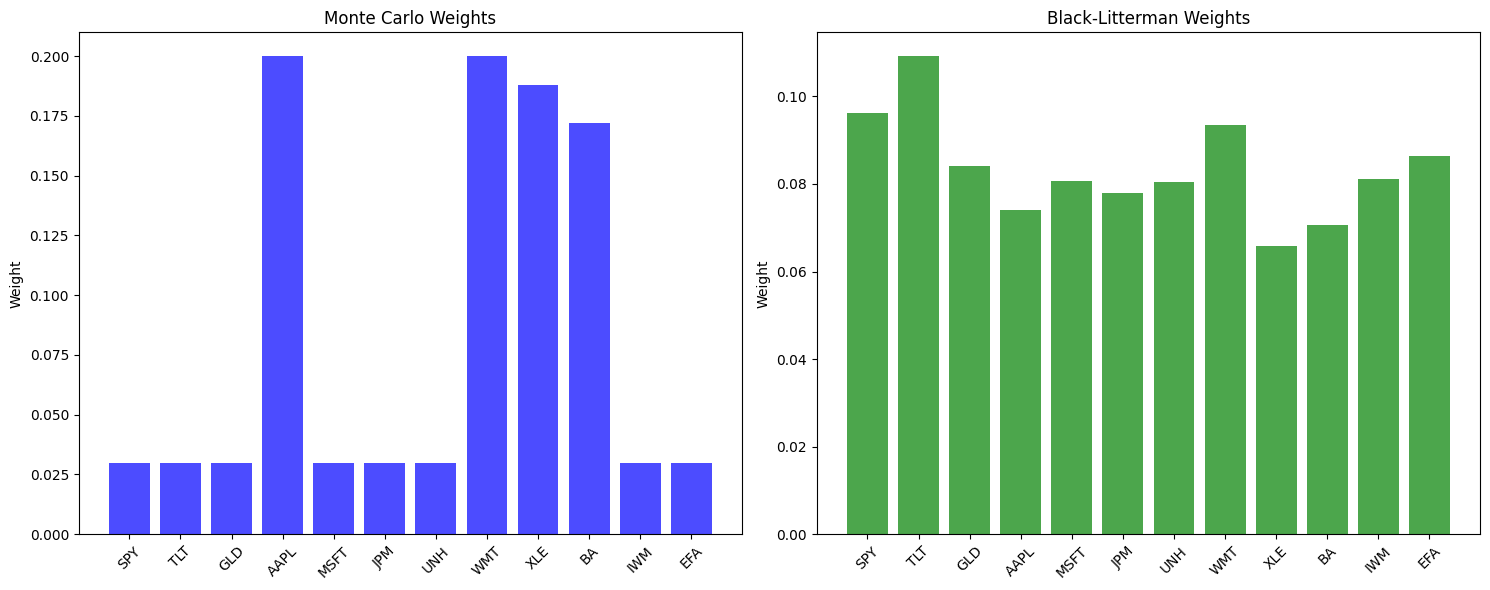

In [13]:
# Compare optimization results
comparison_data = {
    'Metric': ['Expected Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'VaR (95%)'],
    'Monte Carlo': [mc_result['expected_return'], mc_result['volatility'], mc_result['sharpe_ratio'], 
                    mc_result['max_drawdown'], mc_result['var_95']],
    'Black-Litterman': [bl_result['expected_return'], bl_result['volatility'], bl_result['sharpe_ratio'], 
                         bl_result['max_drawdown'], bl_result['var_95']]
}

comparison_df = pd.DataFrame(comparison_data)
print("Optimization Method Comparison:")
print(comparison_df.round(4))

# Plot weight comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Monte Carlo weights
mc_weights = list(mc_result['weights'].values)
ax1.bar(assets, mc_weights, alpha=0.7, color='blue')
ax1.set_title('Monte Carlo Weights')
ax1.set_ylabel('Weight')
ax1.tick_params(axis='x', rotation=45)

# Black-Litterman weights
bl_weights = list(bl_result['weights'].values)
ax2.bar(assets, bl_weights, alpha=0.7, color='green')
ax2.set_title('Black-Litterman Weights')
ax2.set_ylabel('Weight')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Analysis and Recommendations

In [14]:
# Analyze the results
print("Analysis:")
print("=" * 50)

# Check if weights are equal (indicates fallback)
mc_equal = len(set(mc_weights)) == 1
bl_equal = len(set(bl_weights)) == 1

print(f"Monte Carlo equal weights: {mc_equal}")
print(f"Black-Litterman equal weights: {bl_equal}")

# Check concentration
mc_max_weight = max(mc_weights)
bl_max_weight = max(bl_weights)

print(f"\nConcentration analysis:")
print(f"Monte Carlo max weight: {mc_max_weight:.3f}")
print(f"Black-Litterman max weight: {bl_max_weight:.3f}")

# Performance comparison
if mc_result['sharpe_ratio'] > bl_result['sharpe_ratio']:
    print(f"\nMonte Carlo performs better (Sharpe: {mc_result['sharpe_ratio']:.3f} vs {bl_result['sharpe_ratio']:.3f})")
else:
    print(f"\nBlack-Litterman performs better (Sharpe: {bl_result['sharpe_ratio']:.3f} vs {mc_result['sharpe_ratio']:.3f})")

print("\nRecommendations:")
if mc_equal:
    print("- Monte Carlo is falling back to equal weights (check regime detection)")
if bl_equal:
    print("- Black-Litterman is falling back to equal weights (check factor timing views)")
if mc_max_weight > 0.15:
    print("- Monte Carlo portfolio is concentrated (consider diversification constraints)")
if bl_max_weight > 0.15:
    print("- Black-Litterman portfolio is concentrated (consider diversification constraints)")

Analysis:
Monte Carlo equal weights: False
Black-Litterman equal weights: False

Concentration analysis:
Monte Carlo max weight: 0.200
Black-Litterman max weight: 0.109

Monte Carlo performs better (Sharpe: 1.363 vs -0.376)

Recommendations:
- Monte Carlo portfolio is concentrated (consider diversification constraints)
